In [1]:
# Import the warnings module
import warnings

# Ignore (filter out) all warning messages
warnings.filterwarnings("ignore")

In [2]:
# Import the joblib library for efficient saving and loading of scikit-learn models
import joblib
# Import the NumPy library and alias it as np
import numpy as np
# Import the Pandas library and alias it as pd
import pandas as pd
# Import specific functions and classes from scikit-learn for model evaluation
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
# Import the StandardScaler class from scikit-learn for feature scaling
from sklearn.preprocessing import StandardScaler
# Import functions and classes from scikit-learn for data splitting and cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
# Import the PCA (Principal Component Analysis) class from scikit-learn for dimensionality reduction
from sklearn.decomposition import PCA
# Import the TensorFlow library and alias it as tf
import tensorflow as tf

# Import specific modules and classes from Keras for building neural networks
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Import the eli5 library for explaining model predictions
import eli5
# Import the PermutationImportance class from eli5 for feature importance analysis
from eli5.sklearn import PermutationImportance
# Import the matplotlib.pyplot module and alias it as plt for data visualization
import matplotlib.pyplot as plt
# Import the mean_absolute_error function from scikit-learn for regression model evaluation
from sklearn.metrics import mean_absolute_error
# Import the plot_model function from Keras for visualizing the structure of neural networks
from keras.utils.vis_utils import plot_model

In [106]:
# Function to save a model using the save method provided by Keras
def saveModel(model, filename):
    model.save(filename)

# Function to load a model from a file using the joblib library
def loadModel(filename):
    model = joblib.load(filename)
    return model

# Function that returns the fourth character of the filename
def errorModel(filename):
    return filename[3]

In [10]:
# Read a CSV file into a Pandas DataFrame from the specified path
df = pd.read_csv("./kepler-data.csv")

# Drop the specified column ("Unnamed: 0") from the DataFrame in-place
df.drop(columns=["Unnamed: 0"], inplace=True)

In [11]:
# Get all column names from the DataFrame
ALL_COLUMNS = df.columns
# Identify columns containing "err" in their names
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
# Define a list of columns to exclude from analysis
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
# Create a list of columns to use for analysis by excluding the specified columns
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [12]:
# Create a subset DataFrame by filtering out rows where the "koi_disposition" column is not equal to "CANDIDATE"
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [13]:
# Extract feature values from the subset DataFrame using selected columns for analysis
X = subset_df[TO_USE].values

# Extract target labels from the subset DataFrame, converting "CONFIRMED" to 1 and other labels to 0
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [14]:
# Standardize the feature values using the StandardScaler
X = StandardScaler().fit_transform(X)

In [15]:
# Split the dataset into training and testing sets using train_test_split
# - X: Feature values
# - y: Target labels
# - test_size: Percentage of the dataset to allocate to the test set
# - random_state: Seed for reproducibility
# - stratify: Ensures that the class distribution in the training and testing sets is similar to the original distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [16]:
# Function to create a neural network model
def createModel():
    # Build a sequential model with multiple dense (fully connected) layers
    model = Sequential([
        Dense(256, input_dim=X.shape[1], activation='relu'),  # Input layer with 256 units and ReLU activation
        Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
        Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
        Dense(1, activation='sigmoid')   # Output layer with 1 unit and sigmoid activation for binary classification
    ])
    
    # Compile the model with specified optimizer, loss function, and evaluation metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Return the compiled model
    return model

In [17]:
# Function to evaluate the performance of a classification model
def performance(test, pred):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(test, pred)
    
    # Calculate the F1 score
    f1 = f1_score(test, pred)
    
    # Generate a classification report
    report = classification_report(test, pred)
    
    # Calculate the balanced accuracy score
    accuracy = balanced_accuracy_score(test, pred)
    
    # Calculate Cohen's Kappa score
    kappa = cohen_kappa_score(test, pred)
    
    # Print various performance metrics
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [18]:
# Function to train and evaluate a model on a specific fold
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    # Train the model on the training set
    model.fit(X_train, y_train, epochs=20, verbose=0)
    
    # Make predictions on the test set
    pred = model.predict(X_test)
    
    # Convert predictions to binary values based on a threshold of 0.5
    pred = pred >= 0.5
    
    # Calculate the F1 score for evaluation
    f1 = f1_score(y_test, pred)
    
    # Print the F1 score for the current fold
    print(f"F1 Score in fold {fold} = {f1}")
    
    # Return the F1 score for potential further analysis or aggregation
    return f1

# Function to perform K-fold cross-validation
def crossValidation(K=10):
    # Create a KFold object for non-stratified cross-validation
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    
    # Perform K-fold cross-validation without stratification
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        # Create a new model for each fold
        model = createModel()
        
        # Train and evaluate the model on the current fold
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        
        # Append the F1 score for the current fold to the list
        f1_scores.append(current_f1)
        
        # Increment the fold counter
        k_ctr += 1
    
    # Print the average F1 score across all folds
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    # Create a StratifiedKFold object for stratified cross-validation
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    
    # Perform K-fold cross-validation with stratification
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        # Create a new model for each fold
        model = createModel()
        
        # Train and evaluate the model on the current fold
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        
        # Append the F1 score for the current fold to the list
        f1_scores.append(current_f1)
        
        # Increment the fold counter
        k_ctr += 1
    
    # Print the average F1 score across all folds with stratification
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [19]:
# Perform K-fold cross-validation with default value K=10
crossValidation(K=10)

22/22 [==============================] - 0s 1ms/step
F1 Score in fold 1 = 0.9727272727272727
22/22 [==============================] - 0s 1ms/step
F1 Score in fold 2 = 0.9696969696969698
22/22 [==============================] - 0s 1ms/step
F1 Score in fold 3 = 0.9592760180995474
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 4 = 0.9733333333333334
22/22 [==============================] - 0s 972us/step
F1 Score in fold 5 = 0.9765258215962441
22/22 [==============================] - 0s 1ms/step
F1 Score in fold 6 = 0.9876543209876544
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 7 = 0.9814432989690721
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 8 = 0.9764453961456103
22/22 [==============================] - 0s 2ms/step
F1 Score in fold 9 = 0.9815195071868583
22/22 [==============================] - 0s 977us/step
F1 Score in fold 10 = 0.9732142857142857
Average 10-Fold F1 Score = 0.9751836224456849

22/22 [===========

In [20]:
# Create a new neural network model using the createModel function
model = createModel()

# Train the model on the training set (X_train, y_train) for 20 epochs
model.fit(X_train, y_train, epochs=20, verbose=0)

# Make predictions on the test set (X_test)
pred = model.predict(X_test)

# Convert predictions to binary values based on a threshold of 0.5
pred = pred >= 0.5

72/72 [==============================] - 0s 1ms/step


In [21]:
# Evaluate the performance of the model on the test set (y_test, pred)
performance(y_test, pred)

F1 Score: 0.9767441860465117
Kappa Score: 0.965362438968315
Accuracy Score: 0.9815478777343184
Confusion Matrix:
[[1520   14]
 [  21  735]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.97      0.98       756

    accuracy                           0.98      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



In [22]:
# Save the trained neural network model to a file
saveModel(model, "../model/nn-model.h5")

In [23]:
# Create a KerasClassifier model for permutation importance analysis
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)

# Train the model on the entire dataset (X, y)
model_perm.fit(X, y)

# Calculate permutation importance using the PermutationImportance class
perm = PermutationImportance(model_perm, random_state=0).fit(X, y)

In [24]:
# Explain feature weights using the permutation importance results
eli5.explain_weights(perm, feature_names=TO_USE)

Weight,Feature
0.1330 ± 0.0041,koi_fpflag_co
0.1252 ± 0.0050,koi_fpflag_ss
0.1229 ± 0.0063,koi_fpflag_nt
0.0624 ± 0.0030,koi_fpflag_ec
0.0484 ± 0.0027,koi_depth
0.0396 ± 0.0038,koi_duration
0.0353 ± 0.0019,koi_period
0.0317 ± 0.0030,koi_teq
0.0166 ± 0.0037,koi_slogg
0.0122 ± 0.0019,koi_steff


In [25]:
# Access the feature importances obtained from permutation importance analysis
perm.feature_importances_

array([0.13295866, 0.00492868, 0.01660182, 0.00089352, 0.0049575 ,
       0.00325699, 0.00472691, 0.00210408, 0.01216315, 0.0041793 ,
       0.04836434, 0.1229284 , 0.03530769, 0.06240093, 0.0317337 ,
       0.00198878, 0.12517656, 0.03957345, 0.00072058])

In [26]:
# Sort the feature importances and corresponding features in descending order
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse=True)
sorted_features = np.asarray(TO_USE)[order]

# Create a DataFrame to store sorted features and their corresponding importances
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

In [27]:
# Display the top rows of the feature importance DataFrame
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_co,0.132959
1,koi_fpflag_ss,0.125177
2,koi_fpflag_nt,0.122928
3,koi_fpflag_ec,0.062401
4,koi_depth,0.048364


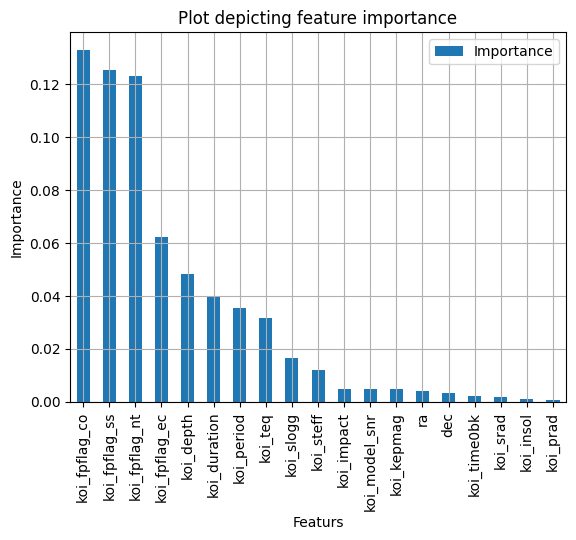

In [28]:
# Plot a bar chart depicting feature importance
feature_importance_df.plot(x='Features', y='Importance', kind='bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig("feat_imp_nn.png", dpi=600)
plt.show()

In [111]:
# Function to handle and log errors
def errormodel(feature):
    # Print the feature causing the error
    print(feature)
    # Print a message indicating that an error occurred
    print("Error Occurred")

In [112]:
# Function to predict the label for a given input using a trained model
def predict_input(model, features):
    try:
        # Standardize the input features
        scaled_features = StandardScaler().fit_transform(features.reshape(1, -1))
        
        # Make predictions using the model
        prediction = model.predict(scaled_features)
        
        # Determine the prediction label based on the threshold of 0.5
        prediction_label = "CONFIRMED" if prediction >= 0.5 else "FALSE POSITIVE"
    except Exception as e:
        # Handle errors by calling the errorModel function and assigning the result to the prediction label
        prediction_label = errorModel(features)
    
    return prediction_label

In [113]:
# Example usage:
# Assuming your data is already loaded into df
input_data_scaled = df.iloc[2].values
# input_data_scaled = StandardScaler().fit_transform(input_data.reshape(1, -1))
# print(input_data_scaled)
# Make prediction
predicted_label = predict_input(model, input_data_scaled)
print(f"The predicted label for the input data is: {predicted_label}")

The predicted label for the input data is: FALSE POSITIVE
